In [1]:
import sys
sys.path.append("..")
from helper import *
from word_embeddings import *
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from pprint import pprint
import matplotlib.pyplot as plt
from operator import itemgetter
from gensim.models import Phrases
import pickle 
import string
import datetime
from collections import Counter
import seaborn as sns
import numpy as np

0. Set paths

In [37]:
PATH_TO_DF = "df.csv"
PATH_TO_MODEL = "model/lda_26topics_500passes_500iter_0.5filterValue.model"

1. Load preprocessed dataframe

In [2]:
# Set path to the preprocessed dataframe
df = pd.read_csv(PATH_TO_DF, sep=",")
df.fillna('', inplace=True)
df.head()

,content,day,index,month,preprocessed,transcriptionName,year
0,hier ist das erste deutsche Fernsehen mit der ...,1,0.0,4,deutsch_fernsehen_tagesschau_gut dame_herr ges...,transcripts/tagesschau_01042007_2000_.txt,2007
1,hier ist das erste deutsche Fernsehen mit der ...,2,1.0,4,deutsch_fernsehen_tagesschau dame_herr jed kle...,transcripts/tagesschau_02042007_2000_.txt,2007
2,hier ist das erste deutsche Fernsehen mit der ...,3,2.0,4,deutsch_fernsehen_tagesschau_gut dame_herr ira...,transcripts/tagesschau_03042007_2000_.txt,2007
3,hier ist das erste deutsche Fernsehen mit der ...,4,3.0,4,deutsch_fernsehen_tagesschau_gut dame_herr kri...,transcripts/tagesschau_04042007_2000_.txt,2007
4,hier ist das erste deutsche Fernsehen mit der ...,5,4.0,4,deutsch_fernsehen_tagesschau dame_herr iran fe...,transcripts/tagesschau_05042007_2000_.txt,2007


2. Load model

In [3]:
# Path to LDA model (.model)
model = gensim.models.LdaModel.load(PATH_TO_MODEL)
id2word = model.id2word

In [4]:
docs = list(df["preprocessed"])
docs = [doc.split(" ") for doc in docs]
corpus = [id2word.doc2bow(doc) for doc in docs]

3. Assign all documents a list of topics

In [5]:
df2 = df.copy()
topic_column = []
for bow in corpus:
    topics = model.get_document_topics(bow, minimum_probability=0.05)
    topic_column.append([val[0] for val in topics])

In [6]:
df2["topics"] = topic_column
df2.head()

,content,day,index,month,preprocessed,transcriptionName,year,topics
0,hier ist das erste deutsche Fernsehen mit der ...,1,0.0,4,deutsch_fernsehen_tagesschau_gut dame_herr ges...,transcripts/tagesschau_01042007_2000_.txt,2007,"[3, 15, 20, 21, 23, 25]"
1,hier ist das erste deutsche Fernsehen mit der ...,2,1.0,4,deutsch_fernsehen_tagesschau dame_herr jed kle...,transcripts/tagesschau_02042007_2000_.txt,2007,"[2, 3, 15, 20, 22, 25]"
2,hier ist das erste deutsche Fernsehen mit der ...,3,2.0,4,deutsch_fernsehen_tagesschau_gut dame_herr ira...,transcripts/tagesschau_03042007_2000_.txt,2007,"[2, 3, 5, 10, 13, 15, 20, 22, 25]"
3,hier ist das erste deutsche Fernsehen mit der ...,4,3.0,4,deutsch_fernsehen_tagesschau_gut dame_herr kri...,transcripts/tagesschau_04042007_2000_.txt,2007,"[2, 3, 10, 11, 13, 20, 22, 25]"
4,hier ist das erste deutsche Fernsehen mit der ...,5,4.0,4,deutsch_fernsehen_tagesschau dame_herr iran fe...,transcripts/tagesschau_05042007_2000_.txt,2007,"[2, 13, 15, 20, 22, 24, 25]"


4. Group topics by year/month/week

In [7]:
df2["Calender Week"] = df2.apply(lambda row:datetime.date(row["year"], row["month"], row["day"]).isocalendar()[1], axis=1)

In [8]:
combined_topics = df2.groupby(["year", "month"])["topics"].apply(list)
combined_topics = combined_topics.apply(lambda x: [val for sublist in x for val in sublist])
combined_topics_week = df2.groupby(["year", "Calender Week"])["topics"].apply(list)
combined_topics_week = combined_topics_week.apply(lambda x: [val for sublist in x for val in sublist])
combined_topics_year = df2.groupby(["year"])["topics"].apply(list)
combined_topics_year = combined_topics_year.apply(lambda x: [val for sublist in x for val in sublist])
combined_topics_year

year
2007    [3, 15, 20, 21, 23, 25, 2, 3, 15, 20, 22, 25, ...
2008    [3, 5, 15, 20, 22, 24, 4, 15, 20, 22, 25, 4, 5...
2009    [3, 13, 15, 17, 24, 25, 2, 3, 17, 20, 25, 3, 1...
2010    [3, 5, 10, 15, 20, 21, 24, 2, 3, 20, 21, 22, 3...
2011    [3, 5, 13, 15, 24, 2, 3, 20, 21, 22, 2, 3, 12,...
2012    [2, 5, 15, 20, 21, 24, 25, 3, 5, 10, 14, 15, 2...
2013    [1, 5, 20, 24, 2, 4, 5, 17, 20, 22, 25, 2, 5, ...
2014    [3, 5, 13, 14, 15, 20, 24, 3, 10, 13, 15, 20, ...
2015    [3, 5, 7, 13, 14, 20, 21, 22, 2, 7, 12, 13, 20...
2016    [3, 4, 13, 21, 22, 24, 1, 3, 7, 14, 20, 22, 1,...
2017    [2, 21, 22, 24, 7, 14, 17, 18, 22, 7, 17, 20, ...
2018    [1, 3, 15, 21, 22, 24, 1, 3, 10, 14, 15, 20, 2...
2019    [1, 11, 18, 20, 22, 24, 1, 2, 11, 20, 22, 1, 2...
2020    [1, 2, 3, 12, 18, 21, 22, 24, 1, 2, 4, 7, 17, ...
Name: topics, dtype: object

In [13]:
columns = [i for i in range(0,26)] + ["date"]
df_counts_month = pd.DataFrame(columns=columns)
df_counts_week = pd.DataFrame(columns=columns)
df_counts_year = pd.DataFrame(columns=columns)

In [16]:
# Create data for month
for y, date in zip(combined_topics.apply(lambda x: Counter(x)), ["{}/{}".format(y,x) for x,y in list(combined_topics.index)]):
    y["date"] = date
    df_counts_month = df_counts_month.append(y, ignore_index=True)
df_counts_month = df_counts_month.fillna(0)
df_counts_month_rel = df_counts_month.iloc[:,:-1].div(df_counts_month.iloc[:,:-1].sum(axis=1), axis=0)
df_counts_month_rel["date"] = df_counts_month["date"]

# Create data for week
for y, date in zip(combined_topics_week.apply(lambda x: Counter(x)), ["{}/{}".format(y,x) for x,y in list(combined_topics_week.index)]):
    y["date"] = date
    df_counts_week = df_counts_week.append(y, ignore_index=True)
df_counts_week = df_counts_week.fillna(0)
df_counts_week = df_counts_week.iloc[1:]
df_counts_week_rel = df_counts_week.iloc[:,:-1].div(df_counts_week.iloc[:,:-1].sum(axis=1), axis=0)
df_counts_week_rel["date"] = df_counts_week["date"]

# Create data for year
for y, date in zip(combined_topics_year.apply(lambda x: Counter(x)), ["{}".format(x) for x in list(combined_topics_year.index)]):
    y["date"] = date
    df_counts_year = df_counts_year.append(y, ignore_index=True)
df_counts_year = df_counts_year.fillna(0)
df_counts_year_rel = df_counts_year.iloc[:,:-1].div(df_counts_year.iloc[:,:-1].sum(axis=1), axis=0)
df_counts_year_rel["date"] = df_counts_year["date"]

In [18]:
# This is how the data looks like
df_counts_month_rel.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,date
0,0.0,0.000000,0.058201,0.089947,0.037037,0.042328,0.005291,0.005291,0.0,0.010582,...,0.005291,0.000000,0.000000,0.126984,0.042328,0.111111,0.010582,0.052910,0.148148,4/2007
1,0.0,0.027624,0.011050,0.099448,0.044199,0.071823,0.000000,0.000000,0.0,0.000000,...,0.000000,0.016575,0.000000,0.138122,0.033149,0.116022,0.005525,0.022099,0.165746,5/2007
2,0.0,0.035088,0.070175,0.122807,0.040936,0.111111,0.005848,0.000000,0.0,0.000000,...,0.000000,0.046784,0.000000,0.111111,0.005848,0.087719,0.035088,0.005848,0.146199,6/2007
3,0.0,0.010204,0.096939,0.137755,0.025510,0.040816,0.000000,0.005102,0.0,0.000000,...,0.010204,0.005102,0.000000,0.147959,0.000000,0.122449,0.051020,0.025510,0.142857,7/2007
4,0.0,0.005848,0.140351,0.087719,0.011696,0.029240,0.000000,0.000000,0.0,0.000000,...,0.000000,0.011696,0.011696,0.146199,0.040936,0.140351,0.040936,0.000000,0.169591,8/2007


In [19]:
# Data for month plot
t1 = df_counts_month_rel.rename({x: str(x) for x in range(0,60)}, axis=1)
t1["X_Axis"] = t1.date
t1 = t1.drop("date", axis=1)
x1 = t1.melt('X_Axis', var_name='cols',  value_name='vals')

# Data for week plot
t2 = df_counts_week_rel.rename({x: str(x) for x in range(0,60)}, axis=1)
t2["X_Axis"] = t2.date
t2 = t2.drop("date", axis=1)
x2 = t2.melt('X_Axis', var_name='cols',  value_name='vals')

# Data for year plot
t3 = df_counts_year_rel.rename({x: str(x) for x in range(0,60)}, axis=1)
t3["X_Axis"] = t3.date
t3 = t3.drop("date", axis=1)
x3 = t3.melt('X_Axis', var_name='cols',  value_name='vals')

5. Rename topics

In [20]:
#model.show_topics(20)
topic_naming = {"0": "Energy revolution",
                "1": "Trump",
                "2": "Natural disasters",
                "3": "Middle east conflict",
                "4": "Political parties/Election",
                "5": "Protests (Austerity)",
                "6": "Brexit",
                "7": "Refugee crisis",
                "8": "FIFA & Breitscheidplatz",
                "9": "Atomic weapons",
                "10": "Trials/Privacy?",
                "11": "German corporations",
                "12": "Corona virus",
                "13": "Russia/Ukraine conflict",
                "14": "Federal government",
                "15": "Victory (Sports/Politics)",
                "16": "Space travel",
                "17": "Syria conflict",
                "18": "Climate change",
                "19": "Greek government-debt crisis",
                "20": "Federal Budget",
                "21": "Bundesliga",
                "22": "Police/Terrorism",
                "23": "Rail strike",
                "24": "Catholic church",
                "25": "Military operations"
                }
x1["cols"] = x1["cols"].replace(topic_naming)
x2["cols"] = x2["cols"].replace(topic_naming)
x3["cols"] = x3["cols"].replace(topic_naming)

6.1 Plot progression (Month)

/home/timur/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


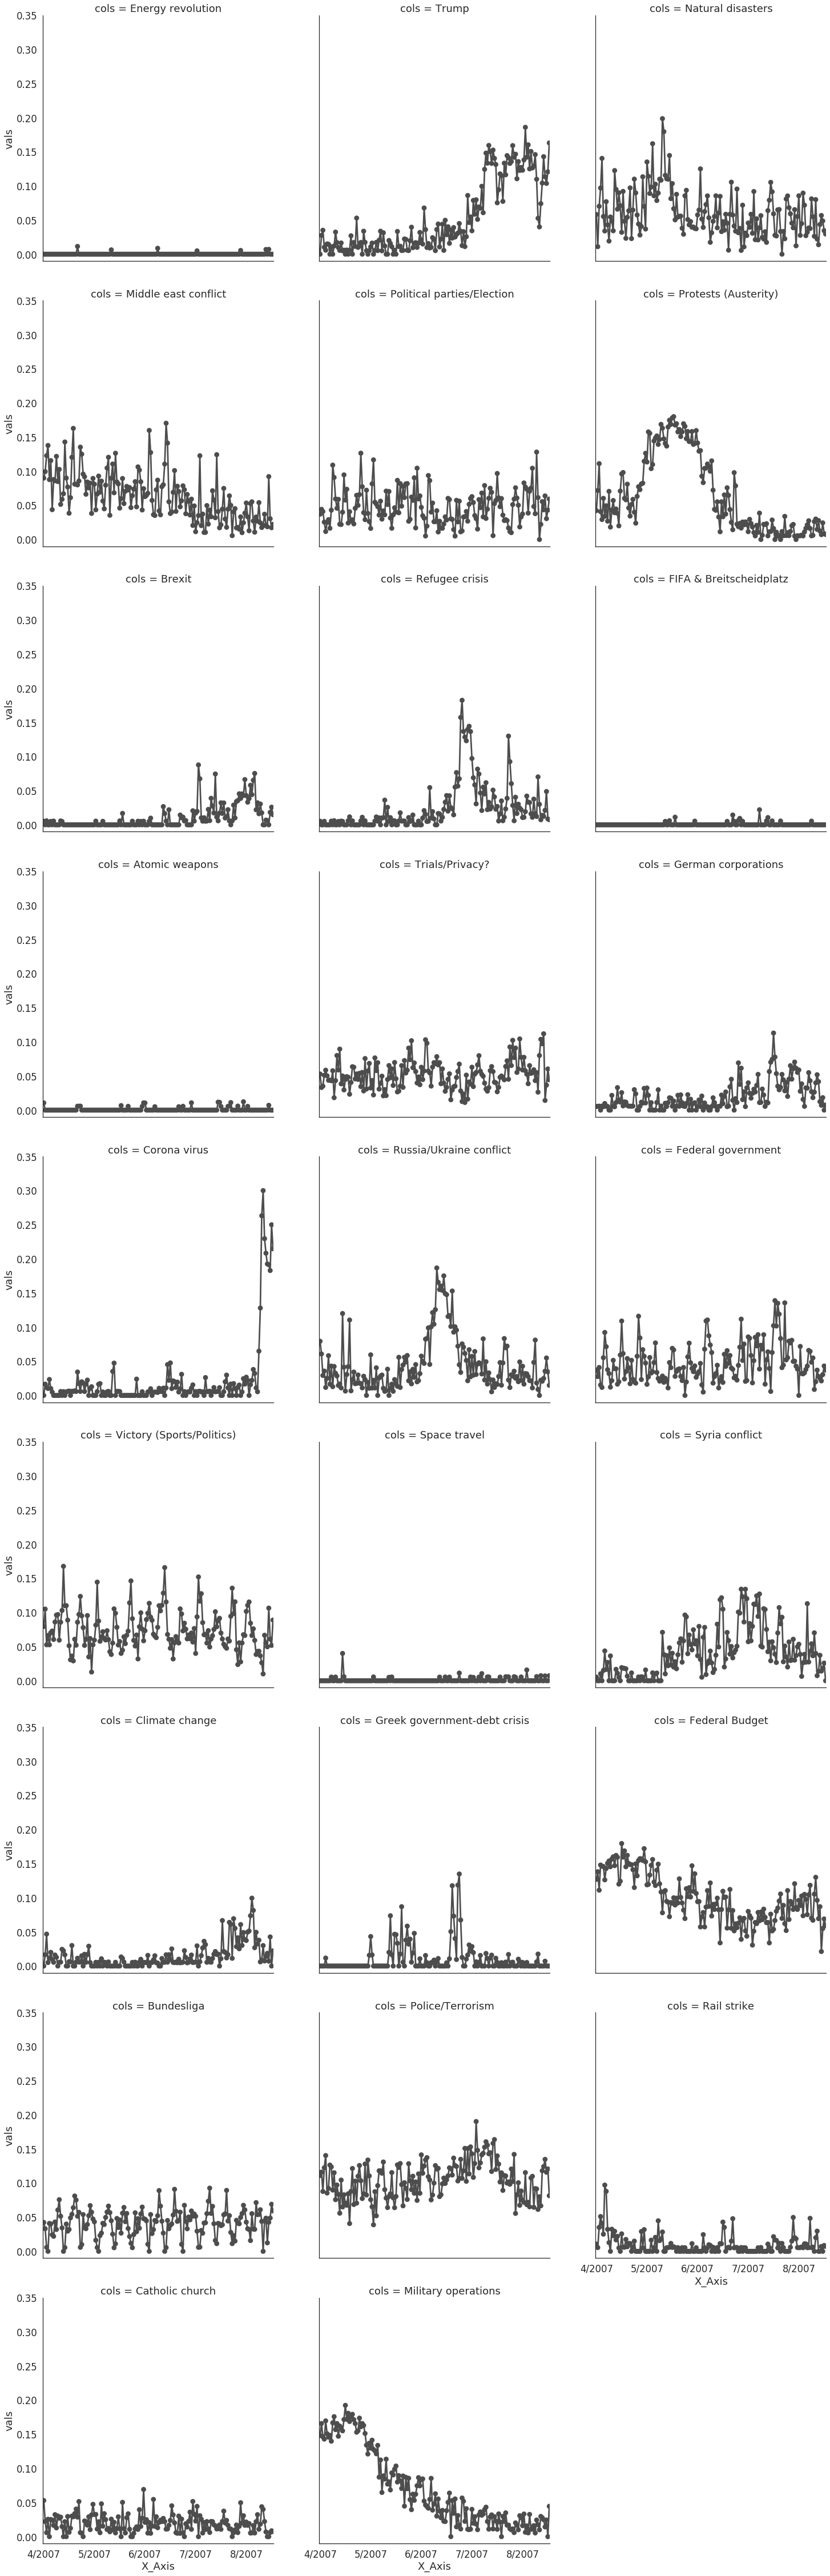

In [25]:
# For the following three plots, the x-axis labels are wrong just fyi
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.FacetGrid(x1, col="cols", col_wrap=3, height=7, ylim=(-0.01, 0.35))
g.map(sns.pointplot, "X_Axis", "vals", color=".3", ci=None)
g.set(xticks=x1["X_Axis"].index[0::36][0:5])

6.2. Plot progression (Week)

/home/timur/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


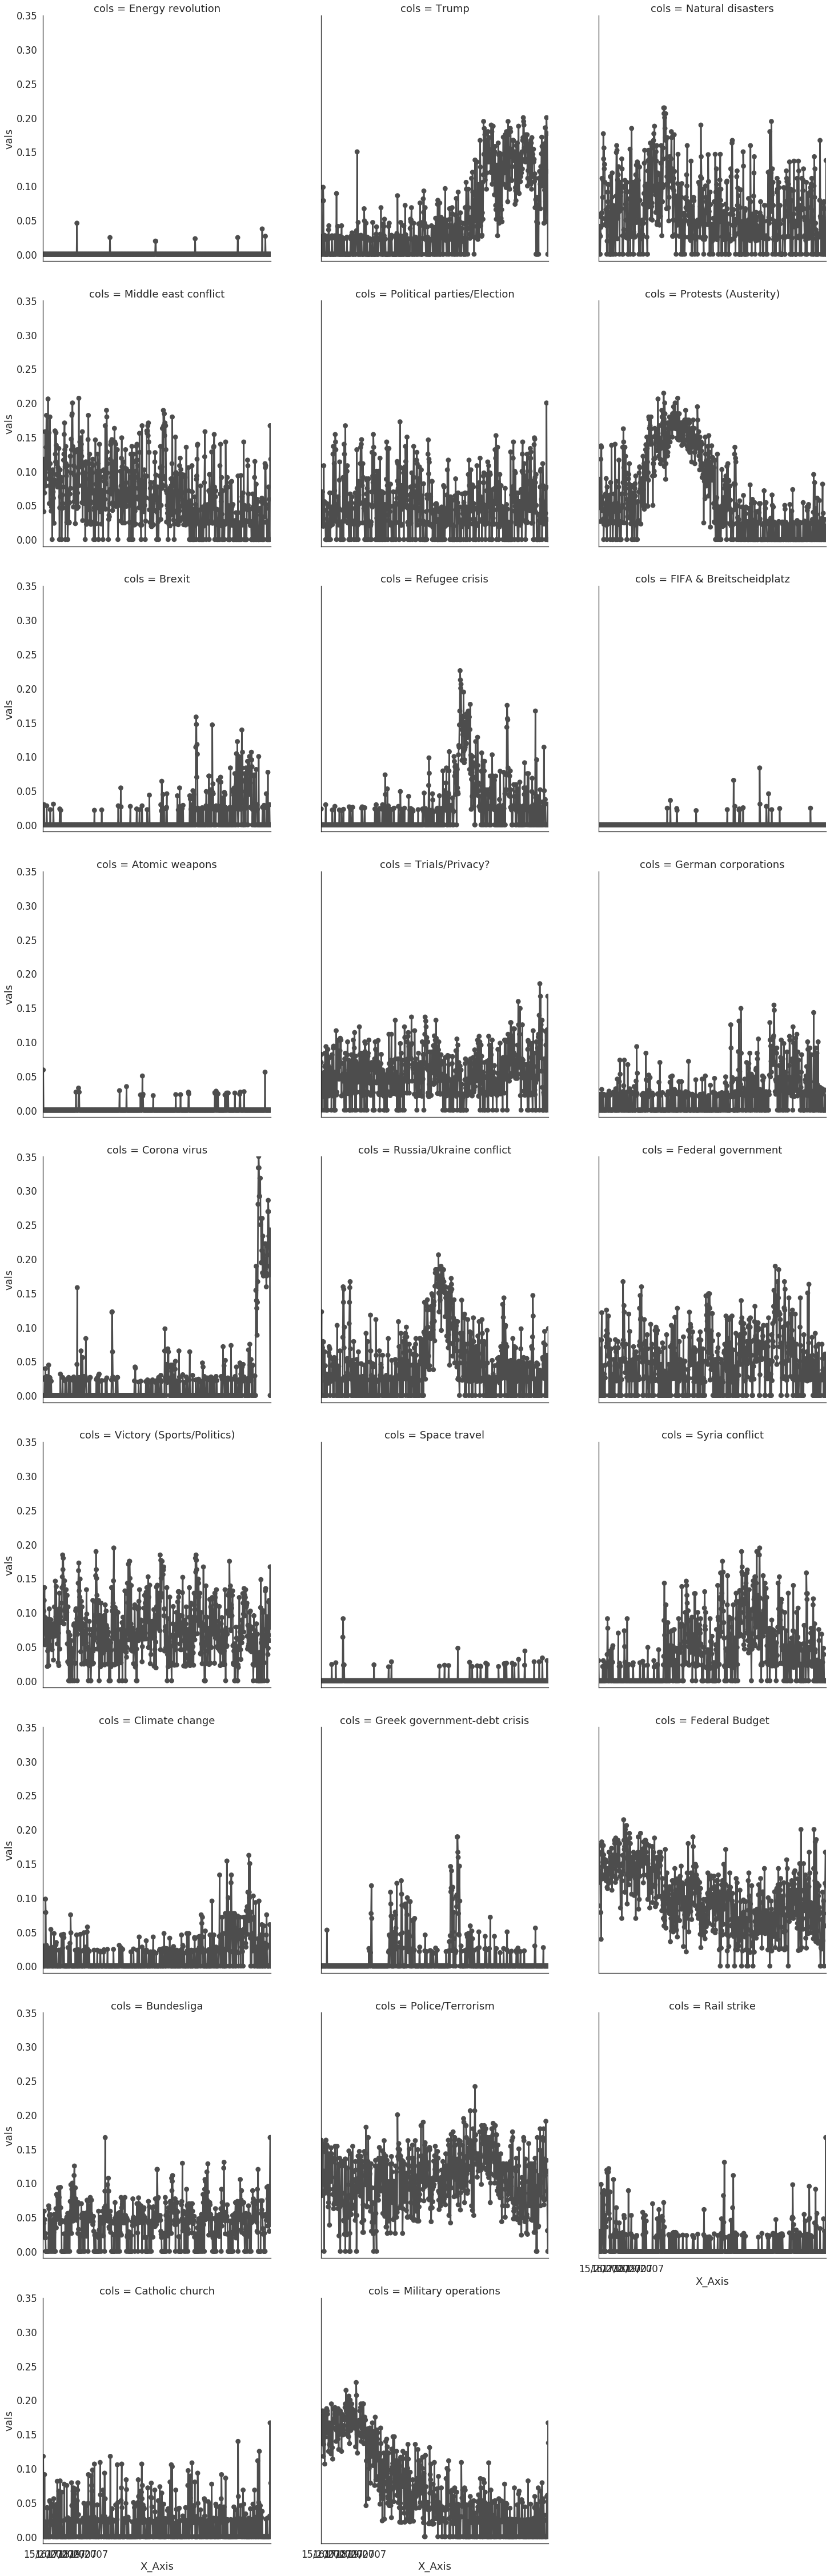

In [27]:
# Takes a while...
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.FacetGrid(x2, col="cols", col_wrap=3, height=7, ylim=(-0.01, 0.35))
g.map(sns.pointplot, "X_Axis", "vals", color=".3", ci=None)
g.set(xticks=x2["X_Axis"].index[0::36][0:5])

6.3 Plot progression (Year)

/home/timur/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


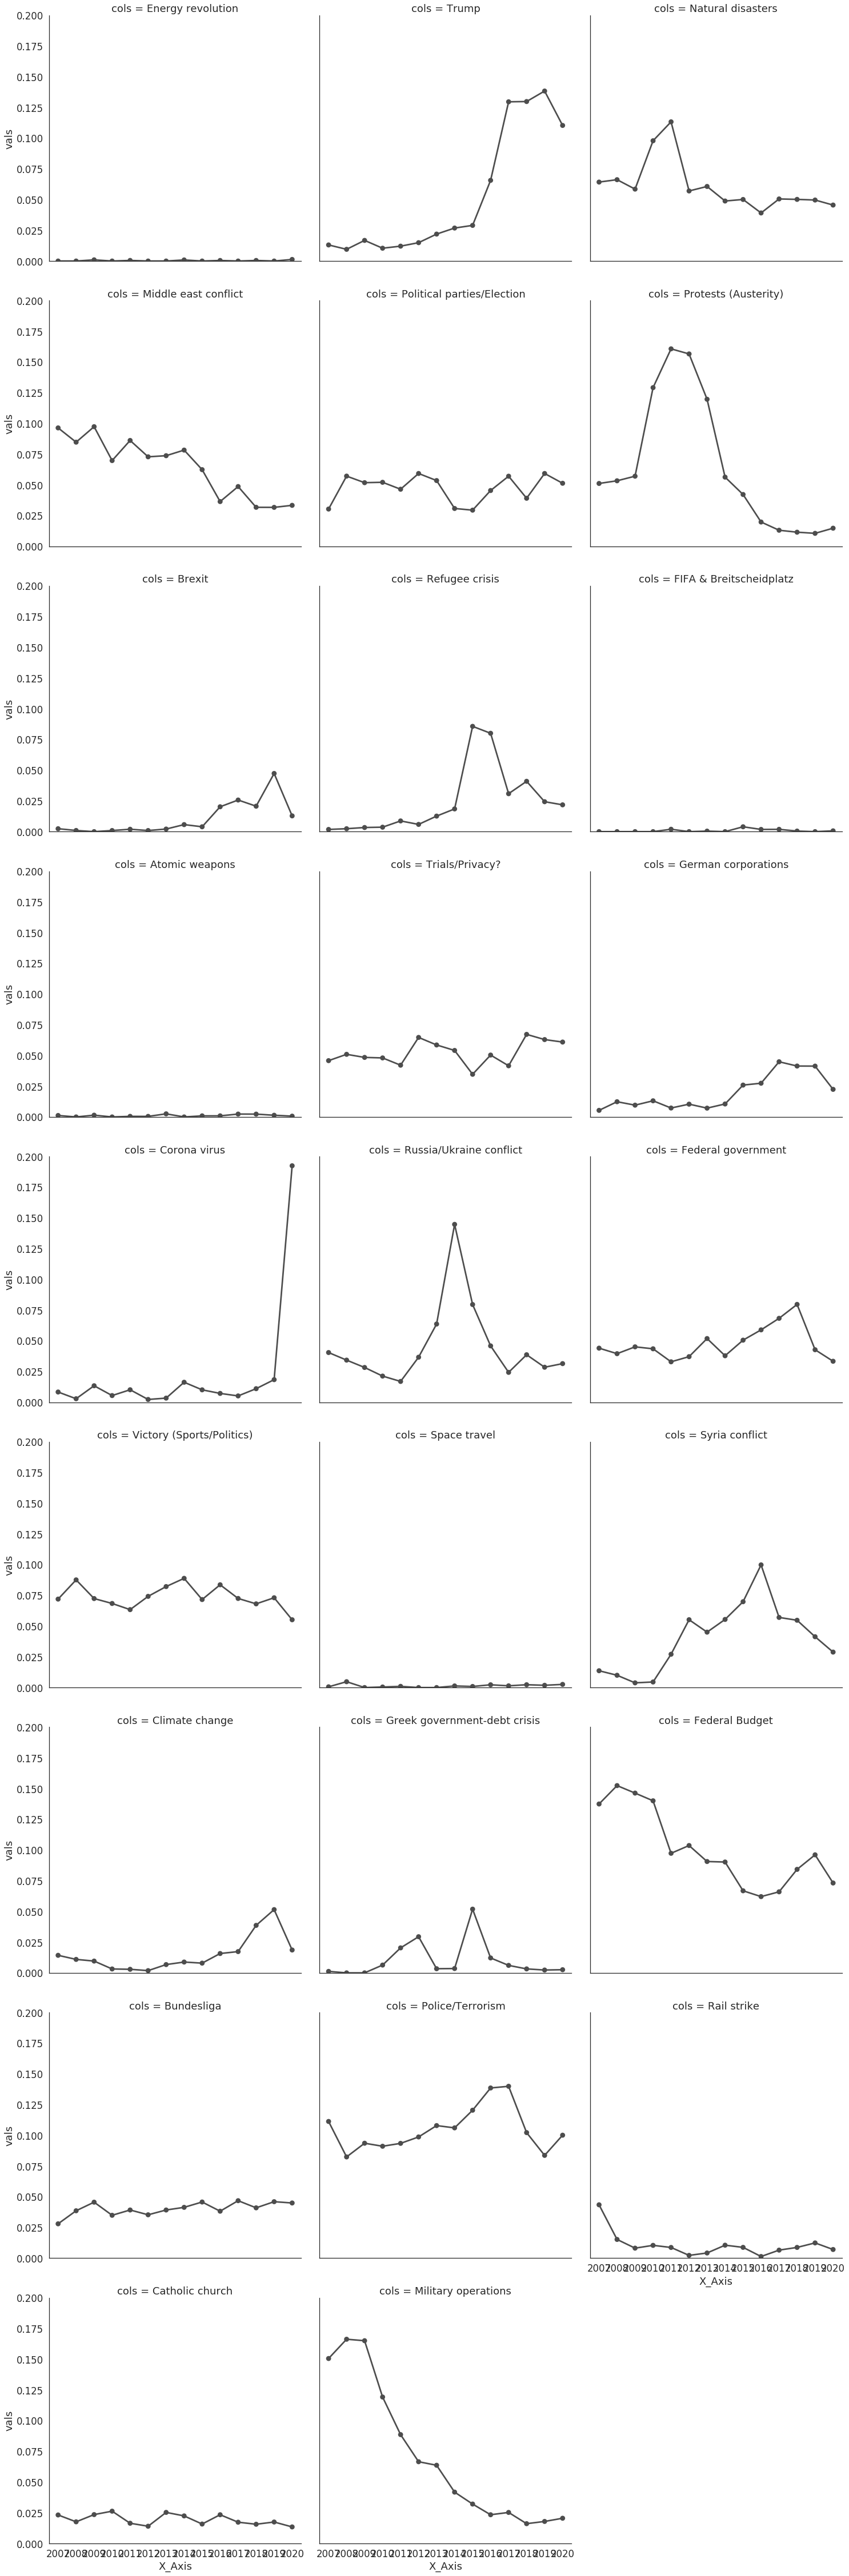

In [32]:
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.FacetGrid(x3, col="cols", col_wrap=3, height=7, ylim=(0, 0.20))
g.map(sns.pointplot, "X_Axis", "vals", color=".3", ci=None)

In [29]:
# Ignore this
"""input_dict = {}
for i in range(26):
    vals = x3.loc[x3["cols"] == str(i)]["vals"].tolist()
    input_dict[str(i)] = vals
input_dict["1"]
df_x = pd.DataFrame(input_dict)
ax = df.plot.area(legend=False)
"""

[]

6.4 Generate plot used in review paper

In [34]:
# Set xticks and labels
l = np.arange(0,164,54)
xtickslabels = x1.reset_index().ix[l]["X_Axis"].tolist()

/home/timur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


/home/timur/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


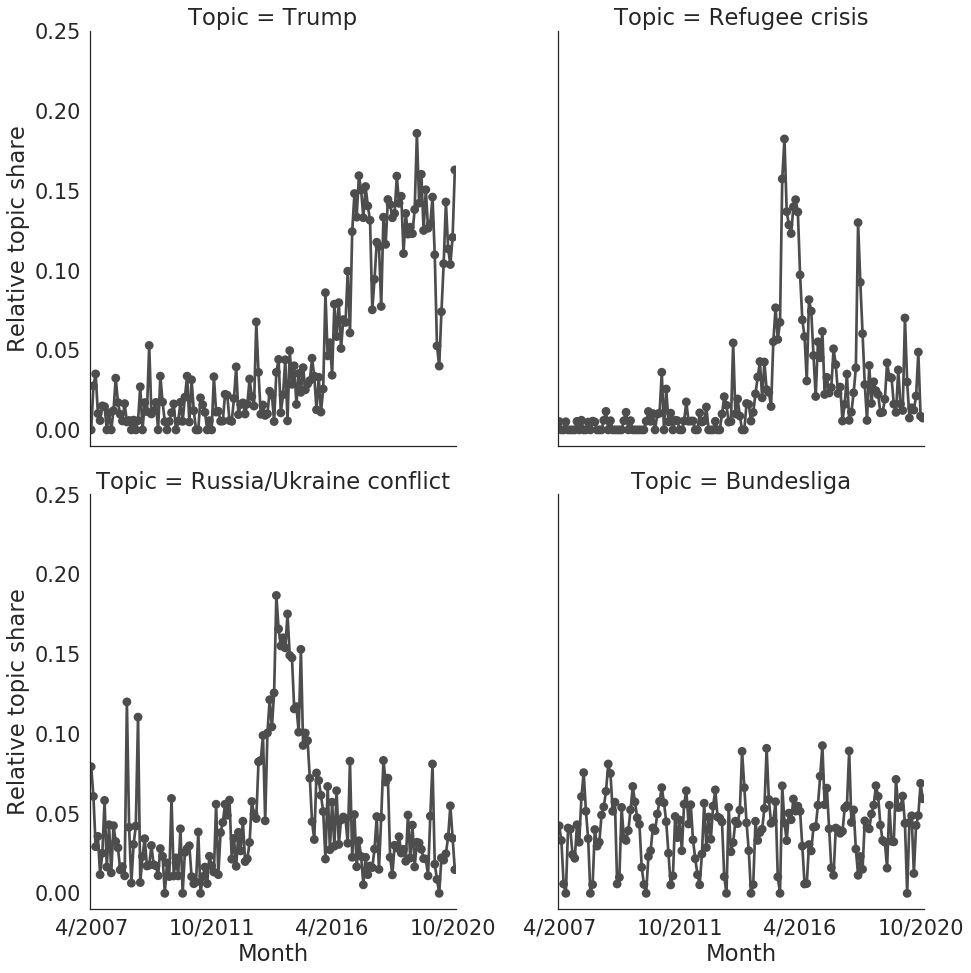

In [36]:
selected = ["Trump", "Refugee crisis", "Russia/Ukraine conflict", "Bundesliga"]
x4 = x1.loc[x1["cols"].isin(selected)]
x4 = x4.rename({"cols": "Topic", "X_Axis": "Month", "vals": "Relative topic share"}, axis=1)
sns.set(font_scale=1.9)
sns.set_style("white")
g = sns.FacetGrid(x4, col="Topic", col_wrap=2, height=7, ylim=(-0.01, 0.25))
g.map(sns.pointplot, "Month", "Relative topic share", color=".3", ci=None)
g.set(xticks=l, xticklabels=xtickslabels)